# Проект "тарифные рекомендации"

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными
тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и
предложить пользователям новый тариф: «Смарт» или «Ультра».

## Цель

Построить модель для задачи классификации, которая будет выберать подходящий тариф на основе поведения пользователя. Минимальная допустимая точность прогноза &mdash; 75%.

## Задачи

Необходимо 
1. построить модели логистической регрессии, решающего дерева и случайного леса;
2. подобрать для моделей гиперпараметры, обеспечивающие наилучшую точность на тестовых данных;
3. выбрать лучшую из моделей по показателю `accuracy`.

## Описание данных

Имеется файл с информацией о поведении клиентов. Каждая строка соответвует одному клиенту:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Загрузка необходимых библиотек и данных

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
import warnings

warnings.simplefilter("ignore")

In [3]:
from graphviz import Source
from IPython.display import HTML, SVG, display

In [4]:
style = "<style>svg{width:70%!important; height: 70%!important;}</style>"
HTML(style);

In [5]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)

In [6]:
try:
    df = pd.read_csv("users_behavior.csv")
except FileNotFoundError:
    df = pd.read_csv("/datasets/users_behavior.csv")

Убедимся, что данные прочитаны адекватно:

In [7]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Видно, что даннные прочитатаны правильно, пропусков нет, типы параметров релевантны данным. 

## Подготовка данных

Сразу же отделим признаки от целевого показателя:

In [9]:
X = df.drop(["is_ultra"], axis=1)
y = df["is_ultra"]

Далее отделим тестовую выборку, выделив под тестовый набор 25% первоначальной выборки. 800 наблюдений это не очень много, но и первоначальная выборка у нас не очень велика. Выборка для исследований содержит примерно 2400 наблюдений

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

## Обучение моделей

### Логистическая регрессия

Начнём с самой простой модели &mdash; логистической регрессии

In [11]:
lr_model = LogisticRegression(random_state=42, n_jobs=8, max_iter=100,).fit(
    X_train,
    y_train,
)
lr_model.score(X_test, y_test)

0.7114427860696517

Видно, что с настройками по умолчанию точность не дотягивает до минимально необходимой. Однако, выбрав дпугой решатель, точность удаётся поднять 

In [12]:
%%time
lr_model = LogisticRegression(random_state=42, n_jobs=8, solver="newton-cg").fit(
    X_train, y_train
)

CPU times: user 6.89 ms, sys: 0 ns, total: 6.89 ms
Wall time: 530 ms


In [25]:
%%time
lr_model.score(X_test, y_test)

CPU times: user 2.55 ms, sys: 420 µs, total: 2.97 ms
Wall time: 2.22 ms


0.7549751243781094

/home/sam/.local/share/virtualenvs/00_Praktikum-W4BAQCOP/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sam/.local/share/virtualenvs/00_Praktikum-W4BAQCOP/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Теперь точность предсказания логиситческой регрессии отвечает целевым показателям точности, хотя и по самой грани. Скорее всего на новых данных, хоть немного отличающихся от тренеровочной выборки, точность предсказания снизится и упадёт ниже целевых 75%.

#### Выводы

Путём подбора гиперпараметра `solver` (решатель) удалось добиться точности предсказания на тестовой выборке на уровне 75.5%, что формально удовлетворяет требованиям. Но превышение порога настолько невилико, что вряд ли будет устойчивым: малейшие изменения во входных данных, скорее всего, снизит показатель `accuracy` ниже порогового значения. 

### Решающее дерево

Следующая сравнительно простая модель &mdash; решающее дерево. Эта модель уже имеет достаточно большое количество гиперпараметров, перебор которых может заметно влиять на качество обучения и точность прогнозов. Для автоматизации подбора гиперпараметров воспользуемся кросс-валидацией с перебором по сетке гиперпараметров. Наибольший вклад в поведение дерева даёт его максимальная глубина, её и будем варьировать:

In [14]:
dt_gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={"max_depth": range(2, 10 + 1)},
    n_jobs=8,
    cv=5,
).fit(X_train, y_train)
dt_gs.best_score_

0.787966804979253

In [15]:
dt_gs.best_estimator_

DecisionTreeClassifier(max_depth=3, random_state=42)

In [16]:
%%time
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_train, y_train)

CPU times: user 6.56 ms, sys: 988 µs, total: 7.55 ms
Wall time: 7.12 ms


In [24]:
%%time
dt_model.score(X_test, y_test)

CPU times: user 4.18 ms, sys: 50 µs, total: 4.23 ms
Wall time: 3.03 ms


0.804726368159204

Даже с минимальным тюнингом небольшое дерево с глубиной 3 уверенно вписывается в требования по точности и превосходит по этому показателю логистическую регрессию. То, что показатель `accuracy`, полученный на кросс-валидации не снизился (а даже немного вырос) с переходом к тостовой выборке, указывает на то, что дерево не переобучилось. Интересно, что обучается такое короткое решающее дерево обучается почти также быстро как логистическая регрессия.

Замечательным свойством решающего дерева является его человекопонятность. Такое небольшое дерево даже можно легко визуализировать:

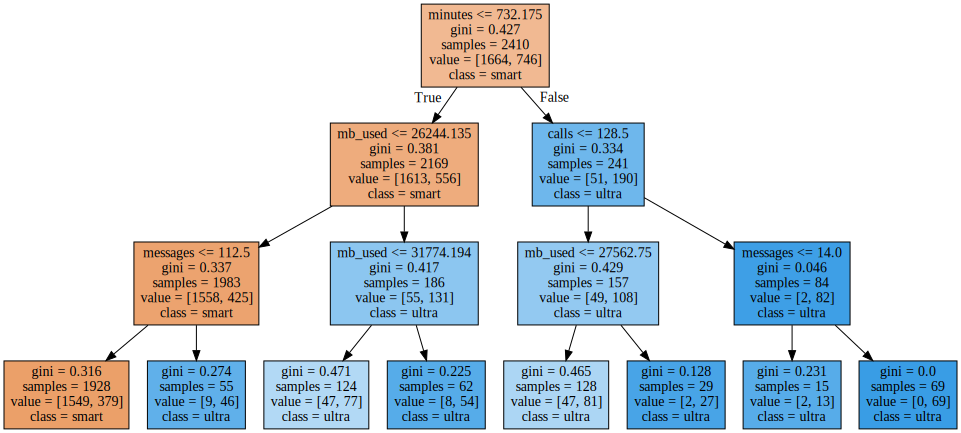

In [18]:
graph = Source(
    export_graphviz(
        dt_model,
        out_file=None,
        feature_names=list(X_test),
        class_names=["smart", "ultra"],
        filled=True,
    )
)
display(SVG(graph.pipe(format="svg")))

#### Выводы

Решающее дерево даже небольшой глубины показывает уверенное соответствие требованиям по точности: 80.5% на тестовой выборке. 5-процентный запас внушает уверенность в устойчивости модели к измененим во входных данных. 

Дополнительный плюс решающего дерева в том, что оно работает достаточно быстро и поддаётся понятной интерпретации человеком.

### Случайный лес

Теперь применим к нашим данным случайный лес. Первоначальный подбор гиперпараметров опять будем проводить с помощью кросс-валидации. На этот раз будем перебирать количество деревьев в лесу и максимальную глубину деревьев:

In [19]:
rf_params = {
    "n_estimators": range(10, 15 + 1),
    "max_depth": range(7, 13 + 1),
}
rf_gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    n_jobs=-1,
    cv=5,
).fit(X_train, y_train)
rf_gs.best_score_

0.8012448132780083

In [20]:
rf_gs.best_estimator_

RandomForestClassifier(max_depth=11, n_estimators=12, random_state=42)

Теперь обучим полученный лес на всей тренировочной выборке и посмотрим точность на тестовой выборке 

In [21]:
%%time
rf_model = RandomForestClassifier(
    n_estimators=12,
    max_depth=11,
    random_state=42,
    n_jobs=-1,
).fit(X_train, y_train)

CPU times: user 84.8 ms, sys: 8.57 ms, total: 93.3 ms
Wall time: 45.3 ms


In [23]:
%%time
rf_model.score(X_test, y_test)

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 8.71 ms


0.818407960199005

Случайный лес демонстрирует набольшее значение `accuracy` заметно выше требуемых 75%. Сравнение точности на кросс-валидации и на тестовой выборке показывает, что лес не переобучен, что не удивительно, ввиду стойкости данной модели к переобучению.

#### Выводы

Случайный лес легко удовлетворяет требованиям по `accuracy`: почти 82% на тестовой выборке. К недостаткам данной модели можно отнести затруднительную интерпретация модели (понять, почему в данном конкретном случае сработала та или иная комбинация выводов 12 деревьев с глубиной 11 будет не просто). Другой существенный недостаток случайного леса &mdash; большое время обучения и работы: обучение нашего леса длилось примерно в 13 раз больше, чем обучение логистической регрессии и решающего дерева. Предсказания делаются тоже медленне, но "всего" в 3-4 раза. На нашей небольшой выборке это не важно, но на больших массивах данных это может стать проблемой.

## Общие выводы

В ходе исследования были построены модели логистической регрессии, решающего дерева и случайного леса. В результате настройки гиперпараметров моделей удалось добиться `accuracy` выше требуемых 75%.

- Использование **логистической регрессии** представляется малоперспективным: точность модели на тестовых данных оказалась всего на доли процента выше порога. На новых данных модель легко может опуститься в точности прогноза ниже 75%. По производительности она несущественно опережает решающее дерево.
- **Решающее дерево** показало уверенное превышения порога точности и  высокую скорость работы.
- **Случайный лес** лишь на пару процентов обогнал решающее дерево по точности, но оказался на порядок более медленным в обучении и в 3 раза более медленным в прогнозировании. 